# **Turkish Sentiment Analysis Finetuning**

In this assignment, you are asked to finetune multiple language models with a specialized movie review dataset in Turkish. Steps to the assignment:
1. Download the dataset. You can download the data from this link: https://mpechen.win.tue.nl/projects/smm/Turkish_Movie_Sentiment.zip (Erkin Demirtas and Mykola Pechenizkiy. Cross-Lingual Polarity Detection with Machine Translation. In Proceedings of the Second International Workshop on Issues of Sentiment Discovery and Opinion Mining, page 9. ACM, 2013.)
1. Make EDA on the dataset (e.g., most common words in positive vs negative, plots showing the length of the entries, etc.)
1. Split your dataset into train/dev/test sets with 0.70/0.15/0.15 proportions. Select a random state number and use it consistently to get the same sets while iterating. **This is very important!**
1. Finetune three models using the training dataset, one for each structure of LLMs (i.e., encoder-only, decoder-only, and encoder-decoder systems): Use BERTurk as the encoder-only model. Please select one decoder-only and one encoder-decoder language model yourself. Some examples could be Gemma, Qwen, MT5, BART, and Llama.
1. Show at least three experiments of hyperparameter tuning (e.g., temperature, learning rate, epoch) - change at least three different parameters for each model.
1. Compare your chosen language models and show f1-scores for your experiments.
1. Write a small report on your approaches and results.

#Notes
1. You can use your Tinker credits for this task and choose one of the available models there. If you have access to either Gemini pro, you can use your account to finetune models too.
1. Tokenize your dataset using the pretrained tokenizer of the language model you select.
1. You can use smaller models, LORA, lower batch sizes, etc. if your CPU is not enough for the job and you do not have Tinker credits.


## Rules
### Allowed:
 - Use any libraries.
 - Add code blocks to the notebook.

### Not allowed:
 - Training your code with the test split of your data. Use validation test for model improvements. Use the test test only for reporting purposes in the end.
 - Using others' codes. We will check the overlaps across the submissions.

## Assignment Report
Please write a short assignment report at the end of the notebook (max 1000 words). Please include all of the following points in the report:
 - Preprocessing method - if you have done any
 - Selection of the language models and the reasoning for the selections
 - Selection of the hyperparameters and the reasoning for the selections
 - Table of F1-scores across the models (best results in bold) with different hyperparameters on test data
 - Challenges you have faced while finetuning the system
 - Limitations of your approach
 - Possible improvements to the system

## Grading
You will be graded with the following criteria:
 - running complete code (0.25),
 - clear commenting (0.25),
 - data loading and exploratory data analysis (EDA) (0.5)
 - finetune three models each with three different hyperparameter tuning variations - you should have at least 9 versions in the end (5)
 - assignment report (2).

Total points for this assignment = 8

## Submission

Submission will be made to SUCourse. Please submit your file using the following naming convention.


`studentid_studentname_tokenizer.ipynb  - ex. 26744_aysegulrana_tokenizer.ipynb`


**Deadline is December 29th, 23.55pm.**

**Models I used:**
- Encoder-only: BERTurk
- Decoder-only: Qwen3-1.7B (with LoRA)
- Encoder-decoder: mT5-base

I trained each model with 3 hyperparameter variations (9 total experiments).

## 1. Setup and Data Preparation

In [4]:
# Install required libraries
!pip install -q transformers peft accelerate ftfy tqdm scikit-learn matplotlib pandas numpy wordcloud

# =========================
# Import libraries
# =========================

import os, zipfile, urllib.request, gc, re
import warnings
import transformers

from dataclasses import dataclass  # I use this to create the custom data collator
from typing import List, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    precision_recall_fscore_support
)

import torch
from torch.utils.data import Dataset  # I use this to create custom datasets

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,  # load pre-trained models
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq  # for training
)

from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel  # I use PEFT for efficient fine-tuning with LoRA
)

from tqdm import tqdm  # show progress bars

# to clean and preprocess text
from ftfy import fix_text

# =========================
# Ignore warnings
# =========================

warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00


In [5]:
RANDOM_STATE = 445

#I'm using H100/A100 runtime in colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA A100-SXM4-80GB


In [6]:
# Dataset download settings
ZIP_URL = "https://mpechen.win.tue.nl/projects/smm/Turkish_Movie_Sentiment.zip"
ZIP_NAME = "Turkish_Movie_Sentiment.zip"
DATA_DIR = "Turkish_Movie_Sentiment"

# I only download if the file does not exist to save time
if not os.path.exists(ZIP_NAME):
    print("Downloading dataset...")
    urllib.request.urlretrieve(ZIP_URL, ZIP_NAME)

if not os.path.exists(DATA_DIR):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_NAME, "r") as z:
        z.extractall(DATA_DIR)

# I handle nested folder structure because sometimes zip creates extra folder inside
if os.path.exists(os.path.join(DATA_DIR, "Turkish_Movie_Sentiment")):
    DATA_DIR = os.path.join(DATA_DIR, "Turkish_Movie_Sentiment")

print("Dataset directory:", DATA_DIR)

# Load positive and negative review files
pos_file = os.path.join(DATA_DIR, "tr_polarity.pos")
neg_file = os.path.join(DATA_DIR, "tr_polarity.neg")

# I use errors="ignore" to skip any encoding issues in the text files
with open(pos_file, encoding="utf-8", errors="ignore") as f:
    pos = [line.strip() for line in f if line.strip()]

with open(neg_file, encoding="utf-8", errors="ignore") as f:
    neg = [line.strip() for line in f if line.strip()]

# I create a DataFrame with labels: 1 for positive, 0 for negative
df = pd.DataFrame({
    "text": pos + neg,
    "label": [1] * len(pos) + [0] * len(neg)
})

# I shuffle the data to mix positive and negative samples together
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"Total samples: {len(df)}")
print(f"Positive: {len(pos)} | Negative: {len(neg)}")
df.head()

Extracting dataset...
Dataset directory: Turkish_Movie_Sentiment
Total samples: 10660
Positive: 5330 | Negative: 5330


,text,label
0,"fragman sperdi, gidilecek grlecek filmler aras...",0
1,ay ok ktyd ya ancak 6 yasindaki kuzeninizi gtrn..,0
2,"sevmedim , tamamlanmamis belki de gerekten sad...",0
3,'mutluluk sadece paylasildiginda gerektir.' mk...,1
4,film ok zekice ve byk bir ustalikla hazirlanmi...,1


# Clean/preprocess text

In [7]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # Fix encoding where possible (Ã¼ etc.)
    text = fix_text(text)

    # Remove unrecoverable replacement characters
    text = text.replace("�", "")

    # Lowercase (dataset already lowercased just in case)
    text = text.lower()

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["text"] = df["text"].apply(clean_text)



## 2. Exploratory Data Analysis

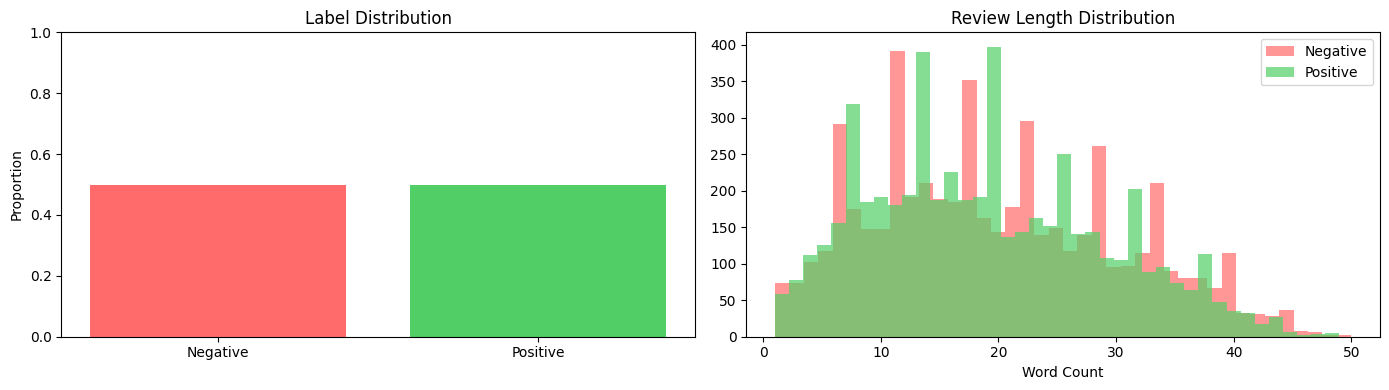

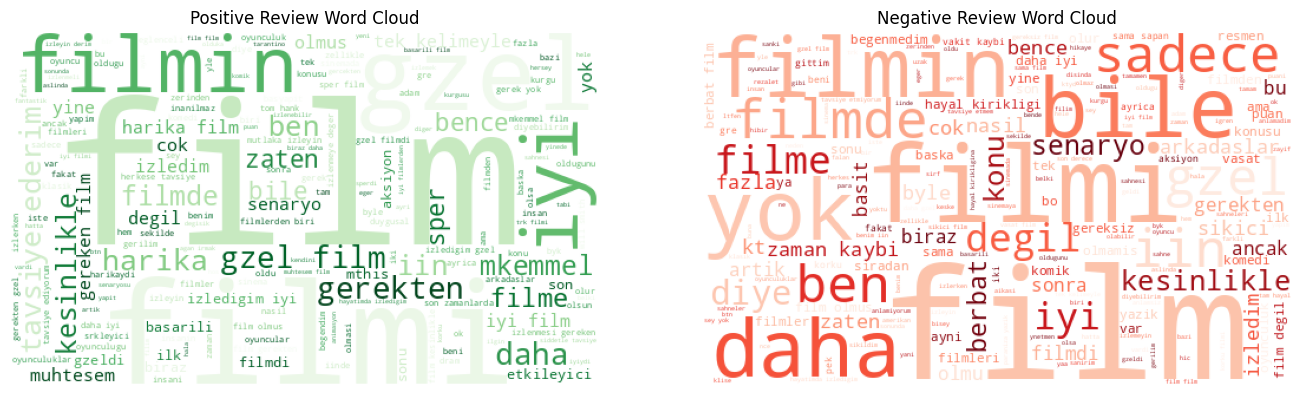

Word count statistics:
count    10660.000000
mean        19.468762
std         10.243323
min          1.000000
25%         11.000000
50%         18.000000
75%         27.000000
max         50.000000
Name: word_count, dtype: float64


In [8]:
# I add word count feature for EDA analysis
df["word_count"] = df["text"].str.split().apply(len)

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot 1: Label distribution (normalised to show proportions)
label_dist = df["label"].value_counts(normalize=True).sort_index()
axes[0].bar(
    ["Negative", "Positive"],
    label_dist.values,
    color=["#ff6b6b", "#51cf66"]
)
axes[0].set_title("Label Distribution")
axes[0].set_ylabel("Proportion")
axes[0].set_ylim(0, 1)

# Plot 2: Review length distribution by sentiment
# I use alpha=0.7 so overlapping bars are visible
axes[1].hist(
    df[df["label"] == 0]["word_count"],
    bins=40,
    alpha=0.7,
    label="Negative",
    color="#ff6b6b"
)
axes[1].hist(
    df[df["label"] == 1]["word_count"],
    bins=40,
    alpha=0.7,
    label="Positive",
    color="#51cf66"
)
axes[1].set_title("Review Length Distribution")
axes[1].set_xlabel("Word Count")
axes[1].legend()

plt.tight_layout()
plt.show()

# I define Turkish stopwords to remove common words from word clouds
# These words appear often but do not show sentiment
stopwords = {
    "ve","bir","bu","da","de","için","ile","o","ki","ne","var",
    "gibi","bence","ama","kadar","sence","bana","göre","olarak",
    "olan","ise","yani","şu","bunu"
}

def collect_words(texts):
    """Join all words from texts, excluding stopwords and short words"""
    return " ".join(
        w for t in texts
        for w in t.lower().split()
        if w not in stopwords and len(w) > 2
    )

# Collect words for positive and negative reviews separately
pos_words = collect_words(df[df["label"] == 1]["text"])
neg_words = collect_words(df[df["label"] == 0]["text"])

# Generate word clouds with different colour schemes for each sentiment
wc_pos = WordCloud(
    width=500,
    height=300,
    background_color="white",
    colormap="Greens"
).generate(pos_words)

wc_neg = WordCloud(
    width=500,
    height=300,
    background_color="white",
    colormap="Reds"
).generate(neg_words)

# Display word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].imshow(wc_pos)
axes[0].set_title("Positive Review Word Cloud")
axes[0].axis("off")

axes[1].imshow(wc_neg)
axes[1].set_title("Negative Review Word Cloud")
axes[1].axis("off")

plt.tight_layout()
plt.show()

print("Word count statistics:")
print(df["word_count"].describe())

## 3. Train/Dev/Test Split (70/15/15)

In [9]:
# Split data into train (70%), dev (15%), and test (15%)
# I first split into train and temp (30%), then split temp into dev and test equally
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=RANDOM_STATE, stratify=df['label'])
dev_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=RANDOM_STATE, stratify=temp_df['label'])

# I use stratify to keep the same label ratio in all splits
train_df = train_df.reset_index(drop=True)
dev_df = dev_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train: {len(train_df)} | Dev: {len(dev_df)} | Test: {len(test_df)}")
print(f"Train labels: {train_df['label'].value_counts().to_dict()}")

Train: 7462 | Dev: 1599 | Test: 1599
Train labels: {1: 3731, 0: 3731}


In [10]:
# List to store results from all experiments
all_results = []

def compute_metrics(eval_pred):
    """Calculate evaluation metrics for model performance"""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)

    # I calculate macro F1 (equal weight to each class) and weighted F1 (by class size)
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    p_w, r_w, f_w, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )

    # I also get per-class metrics to see performance on each sentiment
    p_c, r_c, f_c, s_c = precision_recall_fscore_support(
        labels, preds, average=None, labels=[0, 1], zero_division=0
    )

    return {
        "f1": f_w,  # I return f1 as the main metric for model selection
        "accuracy": acc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f_macro,
        "precision_weighted": p_w,
        "recall_weighted": r_w,
        "f1_weighted": f_w,
        "precision_neg": p_c[0],
        "recall_neg": r_c[0],
        "f1_neg": f_c[0],
        "support_neg": float(s_c[0]),
        "precision_pos": p_c[1],
        "recall_pos": r_c[1],
        "f1_pos": f_c[1],
        "support_pos": float(s_c[1]),
    }

## 4. BERTurk (Encoder-Only)

In [11]:
class TextDataset(Dataset):
    """Custom dataset class for encoder-only models like BERT"""
    def __init__(self, texts, labels, tokenizer, max_len=256):
        # I tokenize all texts at once for efficiency
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Return tokenized input with label for training
        return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}


def train_berturk(lr, epochs, batch_size, name):
    """Train BERTurk model with given hyperparameters"""
    print(f"\n{'='*50}\nBERTurk {name}: lr={lr}, epochs={epochs}, batch={batch_size}\n{'='*50}")

    # I use BERTurk because it is pre-trained on Turkish text
    tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
    model = AutoModelForSequenceClassification.from_pretrained(
        "dbmdz/bert-base-turkish-cased",
        num_labels=2
    )

    # Create datasets for train and dev (test will be used later)
    train_ds = TextDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer)
    dev_ds = TextDataset(dev_df['text'].tolist(), dev_df['label'].tolist(), tokenizer)

    # I set up training arguments with warmup to prevent early overfitting
    args = TrainingArguments(
        output_dir=f'./berturk_{name}',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=lr,
        weight_decay=0.01,  # Regularisation to prevent overfitting
        warmup_ratio=0.1,  # Gradual learning rate increase at start
        eval_strategy="epoch",  # I evaluate on dev set every epoch
        save_strategy="epoch",
        load_best_model_at_end=True,  # I load the best model based on dev performance
        metric_for_best_model="f1",  # I select best model using F1 score
        logging_steps=100,
        report_to="none",
        seed=RANDOM_STATE
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=dev_ds,  # I only use dev set during training
        compute_metrics=compute_metrics
    )

    trainer.train()

    # I only evaluate on dev set to select best hyperparameters
    dev_res = trainer.evaluate(dev_ds)

    print(f"Dev F1: {dev_res['eval_f1']:.4f}")

    # Here store the best checkpoint path explicitly
    best_ckpt = trainer.state.best_model_checkpoint

    result = {
        'model': 'BERTurk',
        'exp': name,
        'lr': lr,
        'epochs': epochs,
        'batch': batch_size,
        'dev_f1': dev_res['eval_f1'],
        'best_ckpt': best_ckpt
    }

    # I clear memory after each experiment to avoid GPU out of memory errors
    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()
    return result


In [12]:
# BERTurk experiments (3 variations)
# I test different learning rates, epochs, and batch sizes to find the best settings
all_results.append(train_berturk(lr=2e-5, epochs=3, batch_size=16, name="exp1"))  # Moderate LR, few epochs
all_results.append(train_berturk(lr=5e-5, epochs=4, batch_size=16, name="exp2"))  # Higher LR, more epochs
all_results.append(train_berturk(lr=1e-5, epochs=5, batch_size=32, name="exp3"))  # Lower LR, most epochs, larger batch


BERTurk exp1: lr=2e-05, epochs=3, batch=16


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Precision Neg,Recall Neg,F1 Neg,Support Neg,Precision Pos,Recall Pos,F1 Pos,Support Pos
1,0.258400,0.267303,0.913006,0.913071,0.914280,0.913054,0.913005,0.914266,0.913071,0.913006,0.892052,0.940000,0.915399,800.000000,0.936508,0.886108,0.910611,799.000000
2,0.193900,0.278550,0.923698,0.923702,0.923794,0.923707,0.923699,0.923799,0.923702,0.923698,0.930203,0.916250,0.923174,800.000000,0.917386,0.931164,0.924224,799.000000
3,0.111300,0.330409,0.921193,0.921201,0.921365,0.921207,0.921194,0.921370,0.921201,0.921193,0.929847,0.911250,0.920455,800.000000,0.912883,0.931164,0.921933,799.000000


Dev F1: 0.9237

BERTurk exp2: lr=5e-05, epochs=4, batch=16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Precision Neg,Recall Neg,F1 Neg,Support Neg,Precision Pos,Recall Pos,F1 Pos,Support Pos
1,0.297200,0.278567,0.907851,0.908068,0.911908,0.908037,0.907848,0.911883,0.908068,0.907851,0.872292,0.956250,0.912343,800.000000,0.951524,0.859825,0.903353,799.000000
2,0.191800,0.325848,0.919309,0.919325,0.919666,0.919334,0.919309,0.919673,0.919325,0.919309,0.931789,0.905000,0.918199,800.000000,0.907543,0.933667,0.920419,799.000000
3,0.094900,0.364542,0.922446,0.922452,0.922577,0.922457,0.922446,0.922582,0.922452,0.922446,0.930025,0.913750,0.921816,800.000000,0.915129,0.931164,0.923077,799.000000
4,0.053800,0.375286,0.924328,0.924328,0.924328,0.924328,0.924328,0.924328,0.924328,0.924328,0.924906,0.923750,0.924328,800.000000,0.923750,0.924906,0.924328,799.000000


Dev F1: 0.9243

BERTurk exp3: lr=1e-05, epochs=5, batch=32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Precision Neg,Recall Neg,F1 Neg,Support Neg,Precision Pos,Recall Pos,F1 Pos,Support Pos
1,0.417900,0.263029,0.907326,0.907442,0.909465,0.907420,0.907324,0.909447,0.907442,0.907326,0.880841,0.942500,0.910628,800.000000,0.938089,0.872340,0.904021,799.000000
2,0.228700,0.245187,0.914945,0.914947,0.914972,0.914944,0.914945,0.914970,0.914947,0.914945,0.911911,0.918750,0.915318,800.000000,0.918033,0.911139,0.914573,799.000000
3,0.167700,0.311582,0.906692,0.906817,0.909030,0.906840,0.906694,0.909048,0.906817,0.906692,0.939271,0.870000,0.903310,800.000000,0.878788,0.943680,0.910078,799.000000
4,0.133600,0.300482,0.918063,0.918074,0.918305,0.918081,0.918063,0.918311,0.918074,0.918063,0.928297,0.906250,0.917141,800.000000,0.908313,0.929912,0.918986,799.000000
5,0.118500,0.314927,0.919320,0.919325,0.919432,0.919330,0.919320,0.919436,0.919325,0.919320,0.926302,0.911250,0.918715,800.000000,0.912562,0.927409,0.919926,799.000000


Dev F1: 0.9193


## 5. Qwen3-1.7B (Decoder-Only with LoRA)

In [13]:
@dataclass
class CausalLMCollator:
    """Custom collator to handle variable length sequences for decoder models"""
    tokenizer: any

    def __call__(self, features: List[Dict]):
        # Find the longest sequence in the batch
        max_len = max(len(f["input_ids"]) for f in features)

        batch = {}
        for key in ["input_ids", "attention_mask", "labels"]:
            padded = []
            for f in features:
                pad_len = max_len - len(f[key])

                # I use -100 for labels so loss ignores padding tokens
                if key == "labels":
                    pad_val = -100
                # Attention mask should be padded with 0
                elif key == "attention_mask":
                    pad_val = 0
                else:
                    pad_val = self.tokenizer.pad_token_id

                padded.append(
                    torch.cat([
                        f[key],
                        torch.full((pad_len,), pad_val, dtype=f[key].dtype)
                    ])
                )

            batch[key] = torch.stack(padded)


        return batch


def train_qwen(lr, epochs, lora_r, lora_alpha, name):
    """Train Qwen model with LoRA for efficient fine-tuning"""
    print(f"\n{'='*50}")
    print(f"Qwen3 {name}: lr={lr}, epochs={epochs}, r={lora_r}, alpha={lora_alpha}")
    print(f"{'='*50}")

    model_name = "Qwen/Qwen3-1.7B"

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    # I set pad token to eos token because Qwen does not have a default pad token
    tokenizer.pad_token = tokenizer.eos_token
    # I use left padding for decoder models to keep the answer at the end
    tokenizer.padding_side = "left"

    # I use float16 to reduce memory usage on GPU
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )

    # I apply LoRA to reduce trainable parameters
    # This makes training faster and uses less memory
    lora_config = LoraConfig(
        r=lora_r,  # Rank of the update matrices
        lora_alpha=lora_alpha,  # Scaling factor for updates
        lora_dropout=0.1,  # Dropout for regularisation
        bias="none",
        task_type=TaskType.CAUSAL_LM,
        target_modules=["q_proj", "v_proj"]  # I only train attention layers
    )
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    def make_prompt(text):
        """Create a simple prompt for sentiment classification"""
        return f"Sentiment (positive/negative): {text}\nAnswer:"

    class QwenDataset(Dataset):
        """Dataset that masks prompt tokens so model only learns to predict the answer"""
        def __init__(self, df):
            self.samples = []

            for _, row in df.iterrows():
                prompt = make_prompt(row["text"])
                label_text = " positive" if row["label"] == 1 else " negative"

                # Tokenize prompt and label separately
                prompt_ids = tokenizer(
                    prompt,
                    truncation=True,
                    max_length=256,
                    return_tensors="pt"
                )["input_ids"].squeeze(0)

                label_ids = tokenizer(
                    label_text,
                    return_tensors="pt"
                )["input_ids"].squeeze(0)

                # Combine prompt and label into single sequence
                input_ids = torch.cat([prompt_ids, label_ids], dim=0)

                attention_mask = torch.ones_like(input_ids)

                # I mask prompt tokens with -100 so loss only applies to the answer
                # This teaches the model to generate the correct sentiment label
                labels = input_ids.clone()
                labels[: len(prompt_ids)] = -100

                self.samples.append({
                    "input_ids": input_ids,
                    "attention_mask": attention_mask,
                    "labels": labels
                })

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            return self.samples[idx]

    train_ds = QwenDataset(train_df)

    # I use gradient accumulation to simulate larger batch size with limited memory
    args = TrainingArguments(
        output_dir=f"./qwen_{name}",
        num_train_epochs=epochs,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,  # Effective batch size = 4 * 4 = 16
        learning_rate=lr,
        weight_decay=0.01,
        warmup_ratio=0.1,
        logging_steps=100,
        save_strategy="epoch",
        fp16=True,  # Mixed precision for faster training
        report_to="none",
        seed=RANDOM_STATE
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        data_collator=CausalLMCollator(tokenizer)
    )

    trainer.train()

    def evaluate(df, desc):
        """Generate predictions and calculate F1 score"""
        model.eval()
        preds = []

        with torch.no_grad():
            for _, row in tqdm(df.iterrows(), total=len(df), desc=desc):
                prompt = make_prompt(row["text"])
                inputs = tokenizer(
                    prompt,
                    return_tensors="pt"
                ).to(model.device)

                # Generate the sentiment prediction
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=5,
                    do_sample=False,  # Greedy decoding for consistent results
                    pad_token_id=tokenizer.pad_token_id
                )

                # Extract only the generated part (after the prompt)
                gen = tokenizer.decode(outputs[0], skip_special_tokens=True)
                gen = gen[len(prompt):].strip().lower()

                # Parse the generated text to get prediction
                if gen.startswith("positive"):
                    preds.append(1)
                elif gen.startswith("negative"):
                    preds.append(0)
                else:
                    # Default to negative if output is unclear
                    preds.append(0)

        return f1_score(df["label"].tolist(), preds, average="weighted")

    # I only evaluate on dev set to select best hyperparameters
    dev_f1 = evaluate(dev_df, "Dev")
    print(f"Dev F1: {dev_f1:.4f}")

    result = {
        "model": "Qwen3-1.7B",
        "exp": name,
        "lr": lr,
        "epochs": epochs,
        "lora_r": lora_r,
        "dev_f1": dev_f1
    }

    # Save adapter explicitly
    adapter_path = f"./qwen_{name}_adapter"
    model.save_pretrained(adapter_path)
    tokenizer.save_pretrained(adapter_path)

    result["base_model"] = model_name
    result["adapter_path"] = adapter_path

    # Clear memory
    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()

    return result


In [14]:
# Qwen experiments (3 variations with LoRA)
# I test different LoRA ranks and learning rates because LoRA needs different settings than full training
all_results.append(train_qwen(lr=2e-4, epochs=2, lora_r=8, lora_alpha=16, name="exp1"))   # Medium rank
all_results.append(train_qwen(lr=1e-4, epochs=3, lora_r=16, lora_alpha=32, name="exp2"))  # Higher rank, more training
all_results.append(train_qwen(lr=3e-4, epochs=2, lora_r=4, lora_alpha=8, name="exp3"))    # Lower rank, faster training


Qwen3 exp1: lr=0.0002, epochs=2, r=8, alpha=16


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/622M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

trainable params: 1,605,632 || all params: 1,722,180,608 || trainable%: 0.0932


The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss
100,0.757100
200,0.330700
300,0.286500
400,0.275600
500,0.264100
600,0.212400
700,0.204500
800,0.206400
900,0.200000


Dev: 100%|██████████| 1599/1599 [06:49<00:00,  3.91it/s]


Dev F1: 0.9056

Qwen3 exp2: lr=0.0001, epochs=3, r=16, alpha=32


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 3,211,264 || all params: 1,723,786,240 || trainable%: 0.1863


The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss
100,0.821200
200,0.369300
300,0.321600
400,0.297300
500,0.280100
600,0.231300
700,0.233200
800,0.217700
900,0.225600
1000,0.145300


Dev: 100%|██████████| 1599/1599 [06:50<00:00,  3.89it/s]


Dev F1: 0.8981

Qwen3 exp3: lr=0.0003, epochs=2, r=4, alpha=8


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 802,816 || all params: 1,721,377,792 || trainable%: 0.0466


The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss
100,0.775600
200,0.340700
300,0.292500
400,0.281800
500,0.267100
600,0.210200
700,0.217200
800,0.204100
900,0.207600


Dev: 100%|██████████| 1599/1599 [06:56<00:00,  3.84it/s]


Dev F1: 0.9024


## 6. mT5-base (Encoder-Decoder)

In [15]:
def train_mt5(lr, epochs, batch_size, name):
    """Train mT5 encoder-decoder model for sentiment classification"""
    print(f"\n{'='*50}\nmT5 {name}: lr={lr}, epochs={epochs}, batch={batch_size}\n{'='*50}")

    # I use mT5-base because it supports 101 languages including Turkish
    tokenizer = AutoTokenizer.from_pretrained("google/mt5-base")
    model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-base")

    class MT5Dataset(Dataset):
        """Dataset for seq2seq model that takes text as input and outputs sentiment label"""
        def __init__(self, df):
            self.data = []
            for _, row in df.iterrows():
                # I add "sentiment:" prefix to tell the model what task to do
                inp = tokenizer(
                    f"sentiment: {row['text'][:400]}",
                    truncation=True,
                    padding='max_length',
                    max_length=256,
                    return_tensors='pt'
                )
                # Target is the sentiment label as text
                tgt = tokenizer(
                    "positive" if row['label']==1 else "negative",
                    return_tensors='pt'
                )
                # I replace padding tokens with -100 so loss ignores them
                labels = tgt['input_ids'].squeeze()
                labels[labels == tokenizer.pad_token_id] = -100

                self.data.append({
                    'input_ids': inp['input_ids'].squeeze(),
                    'attention_mask': inp['attention_mask'].squeeze(),
                    'labels': labels
                })

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx]

    train_ds = MT5Dataset(train_df)
    dev_ds = MT5Dataset(dev_df)

    args = TrainingArguments(
        output_dir=f'./mt5_{name}',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=lr,
        weight_decay=0.01,
        warmup_ratio=0.1,
        eval_strategy='epoch',  # I evaluate on dev set every epoch
        save_strategy='epoch',
        load_best_model_at_end=True,  # I load the best model based on dev loss
        logging_steps=100,
        bf16=True, # theres a bug in mt5 where when fp16 is used the loss returns nan so I use bf16
        report_to='none',
        seed=RANDOM_STATE
    )

    # I use DataCollatorForSeq2Seq to handle encoder-decoder batching properly
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=dev_ds,  # I only use dev set during training
        data_collator=DataCollatorForSeq2Seq(
            tokenizer,
            model=model,
            label_pad_token_id=tokenizer.pad_token_id
        )
    )

    trainer.train()

    def evaluate(df, desc):
        """Generate predictions and calculate F1 score"""
        model.eval()
        preds = []
        with torch.no_grad():
            for _, row in tqdm(df.iterrows(), total=len(df), desc=desc):
                inputs = tokenizer(
                    f"sentiment: {row['text'][:400]}",
                    return_tensors='pt',
                    truncation=True,
                    max_length=256
                ).to(device)

                # Generate the sentiment label
                out = model.generate(**inputs, max_new_tokens=5)
                gen = tokenizer.decode(out[0], skip_special_tokens=True).lower()

                # Check if "positive" is in the output, else classify as negative
                preds.append(1 if 'positive' in gen else 0)

        return f1_score(df['label'].tolist(), preds, average='weighted')

    # I only evaluate on dev set to select best hyperparameters
    dev_f1 = evaluate(dev_df, "Dev")

    print(f"Dev F1: {dev_f1:.4f}")

    # I store the best checkpoint path explicitly
    best_ckpt = trainer.state.best_model_checkpoint

    result = {
        'model': 'mT5-base',
        'exp': name,
        'lr': lr,
        'epochs': epochs,
        'batch': batch_size,
        'dev_f1': dev_f1,
        'best_ckpt': best_ckpt
    }

    # Clear memory
    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()
    return result

In [16]:
# mT5 experiments (3 variations - full fine-tuning)
# I use higher learning rates for mT5 because encoder-decoder models often need them
all_results.append(train_mt5(lr=3e-4, epochs=3, batch_size=16, name="exp1"))  # High LR, moderate epochs
all_results.append(train_mt5(lr=1e-4, epochs=5, batch_size=16, name="exp2"))  # Lower LR, many epochs
all_results.append(train_mt5(lr=5e-4, epochs=4, batch_size=8, name="exp3"))   # Highest LR, smaller batch


mT5 exp1: lr=0.0003, epochs=3, batch=16


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.322200,0.229543
2,0.230700,0.194925
3,0.228200,0.196953


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].
Dev: 100%|██████████| 1599/1599 [02:09<00:00, 12.38it/s]


Dev F1: 0.7055

mT5 exp2: lr=0.0001, epochs=5, batch=16


Epoch,Training Loss,Validation Loss
1,0.558600,0.195228
2,0.181300,0.145546
3,0.129600,0.118617
4,0.129200,0.127450
5,0.091900,0.117167


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].
Dev: 100%|██████████| 1599/1599 [02:11<00:00, 12.12it/s]


Dev F1: 0.9006

mT5 exp3: lr=0.0005, epochs=4, batch=8


Epoch,Training Loss,Validation Loss
1,0.398200,0.234794
2,0.244500,0.228231
3,0.214800,0.185543
4,0.209900,0.199940


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].
Dev: 100%|██████████| 1599/1599 [02:06<00:00, 12.59it/s]


Dev F1: 0.7064


## 7. Results Comparison

In [17]:
# Test functions
def mt5_test_f1(checkpoint_path):
    """
    This function tests a fine-tuned mT5 model on the TEST dataset.
    It uses text generation to predict sentiment labels.
    """
    print(f"Evaluating mT5 test: {checkpoint_path}")

    # Load tokenizer and model from the saved checkpoint
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        checkpoint_path,
        device_map="auto",
        torch_dtype=torch.bfloat16  # bf16 is used to avoid NaN loss issues
    )

    # Set model to evaluation mode
    model.eval()
    preds = []

    # Disable gradient calculation for faster inference
    with torch.no_grad():
        # Iterate over the TEST dataset
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="mT5 Test"):
            # Prepare input text with task prefix
            inputs = tokenizer(
                f"sentiment: {row['text'][:400]}",
                return_tensors="pt",
                truncation=True,
                max_length=256
            ).to(model.device)

            # Generate sentiment prediction
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False
            )
            # Decode generated tokens to text
            decoded = tokenizer.decode(
                outputs[0],
                skip_special_tokens=True
            ).lower()

            # Convert generated text into class label
            if "positive" in decoded:
              preds.append(1)
            elif "negative" in decoded:
              preds.append(0)
            else:
              preds.append(0)


    # Calculate weighted F1 score on TEST labels
    f1 = f1_score(test_df["label"].tolist(), preds, average="weighted")

    # Free GPU memory
    del model
    gc.collect()
    torch.cuda.empty_cache()

    return f1


def qwen_test_f1(base_model, adapter_path):
    """
    This function tests the Qwen model with a LoRA adapter on the TEST dataset.
    The model generates text, which is then parsed to obtain sentiment labels.
    """
    print(f"Evaluating Qwen test: {adapter_path}")

    # Load tokenizer from adapter directory
    tokenizer = AutoTokenizer.from_pretrained(
        adapter_path,
        trust_remote_code=True
    )

    # Set padding configuration for decoder-only model
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"

    # Load base Qwen model
    model = AutoModelForCausalLM.from_pretrained(
        base_model,
        device_map="auto",
        torch_dtype=torch.float16,
        trust_remote_code=True
    )

    # Load LoRA adapter weights
    model = PeftModel.from_pretrained(model, adapter_path)
    model.eval()

    preds = []

    # Prompt template for sentiment classification
    def make_prompt(text):
        return f"Sentiment (positive/negative): {text}\nAnswer:"

    # Disable gradients during testing
    with torch.no_grad():
        # Iterate over the TEST dataset
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Qwen Test"):
            prompt = make_prompt(row["text"])

            # Tokenize prompt
            inputs = tokenizer(
                prompt,
                return_tensors="pt",
                truncation=True,
                max_length=256
            ).to(model.device)

            # Generate model output
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )

            # Decode generated text
            gen = tokenizer.decode(
                outputs[0],
                skip_special_tokens=True
            )

            # Remove prompt part and normalize text
            gen = gen[len(prompt):].strip().lower()

            # Convert generated text into class label
            preds.append(1 if 'positive' in gen else 0)



    # Calculate weighted F1 score on TEST labels
    f1 = f1_score(test_df["label"].tolist(), preds, average="weighted")

    # Free GPU memory
    del model
    gc.collect()
    torch.cuda.empty_cache()

    return f1


ALL RESULTS (DEV SET)
     model  exp      lr  epochs  batch   dev_f1                      best_ckpt  lora_r      base_model        adapter_path
   BERTurk exp1 0.00002       3   16.0 0.923698  ./berturk_exp1/checkpoint-934     NaN             NaN                 NaN
   BERTurk exp2 0.00005       4   16.0 0.924328 ./berturk_exp2/checkpoint-1868     NaN             NaN                 NaN
   BERTurk exp3 0.00001       5   32.0 0.919320 ./berturk_exp3/checkpoint-1170     NaN             NaN                 NaN
Qwen3-1.7B exp1 0.00020       2    NaN 0.905552                            NaN     8.0 Qwen/Qwen3-1.7B ./qwen_exp1_adapter
Qwen3-1.7B exp2 0.00010       3    NaN 0.898061                            NaN    16.0 Qwen/Qwen3-1.7B ./qwen_exp2_adapter
Qwen3-1.7B exp3 0.00030       2    NaN 0.902431                            NaN     4.0 Qwen/Qwen3-1.7B ./qwen_exp3_adapter
  mT5-base exp1 0.00030       3   16.0 0.705482      ./mt5_exp1/checkpoint-934     NaN             NaN              

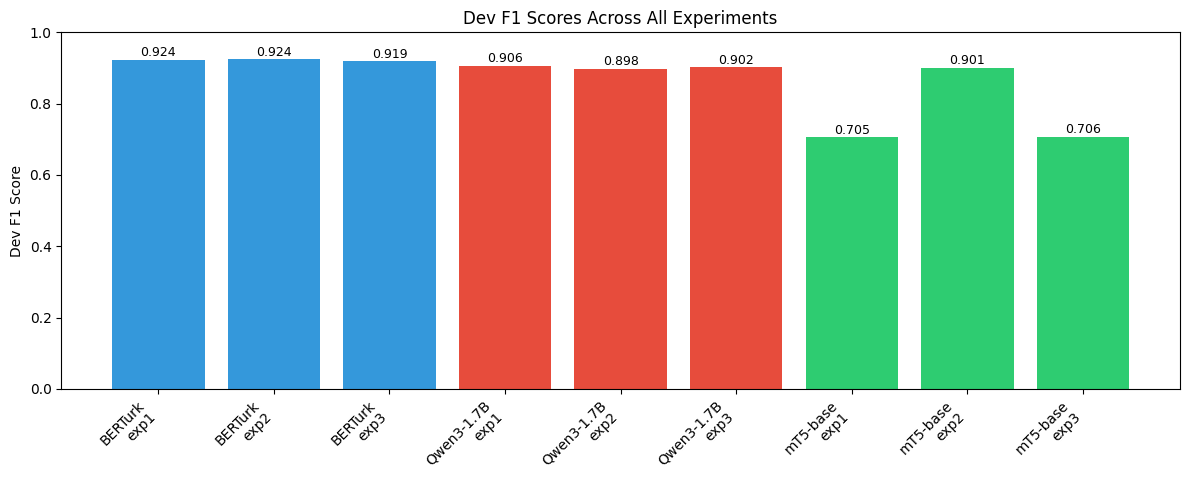


FINAL TEST SET EVALUATION (ALL EXPERIMENTS)
Evaluating all 9 versions on test set for the comparative report table...

--- Processing BERTurk | exp1 ---



--- Processing BERTurk | exp2 ---



--- Processing BERTurk | exp3 ---



--- Processing Qwen3-1.7B | exp1 ---
Evaluating Qwen test: ./qwen_exp1_adapter


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen Test: 100%|██████████| 1599/1599 [07:02<00:00,  3.79it/s]



--- Processing Qwen3-1.7B | exp2 ---
Evaluating Qwen test: ./qwen_exp2_adapter


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen Test: 100%|██████████| 1599/1599 [07:02<00:00,  3.78it/s]



--- Processing Qwen3-1.7B | exp3 ---
Evaluating Qwen test: ./qwen_exp3_adapter


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen Test: 100%|██████████| 1599/1599 [07:02<00:00,  3.79it/s]



--- Processing mT5-base | exp1 ---
Evaluating mT5 test: ./mt5_exp1/checkpoint-934


The tokenizer you are loading from './mt5_exp1/checkpoint-934' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
mT5 Test: 100%|██████████| 1599/1599 [02:01<00:00, 13.15it/s]



--- Processing mT5-base | exp2 ---
Evaluating mT5 test: ./mt5_exp2/checkpoint-2335


The tokenizer you are loading from './mt5_exp2/checkpoint-2335' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
mT5 Test: 100%|██████████| 1599/1599 [02:02<00:00, 13.07it/s]



--- Processing mT5-base | exp3 ---
Evaluating mT5 test: ./mt5_exp3/checkpoint-2799


The tokenizer you are loading from './mt5_exp3/checkpoint-2799' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
mT5 Test: 100%|██████████| 1599/1599 [01:57<00:00, 13.64it/s]



COMPREHENSIVE TEST RESULTS TABLE (BEST PER MODEL HIGHLIGHTED)
| model      | exp   |     lr |   epochs | batch   |   dev_f1 | test_f1    |
|:-----------|:------|-------:|---------:|:--------|---------:|:-----------|
| BERTurk    | exp1  | 2e-05  |        3 | 16.0    | 0.923698 | **0.9206** |
| BERTurk    | exp2  | 5e-05  |        4 | 16.0    | 0.924328 | 0.9181     |
| BERTurk    | exp3  | 1e-05  |        5 | 32.0    | 0.91932  | **0.9206** |
| Qwen3-1.7B | exp1  | 0.0002 |        2 | N/A     | 0.905552 | 0.8862     |
| Qwen3-1.7B | exp2  | 0.0001 |        3 | N/A     | 0.898061 | **0.8968** |
| Qwen3-1.7B | exp3  | 0.0003 |        2 | N/A     | 0.902431 | 0.8831     |
| mT5-base   | exp1  | 0.0003 |        3 | 16.0    | 0.705482 | 0.6840     |
| mT5-base   | exp2  | 0.0001 |        5 | 16.0    | 0.900563 | **0.8868** |
| mT5-base   | exp3  | 0.0005 |        4 | 8.0     | 0.706408 | 0.7036     |


In [18]:
# -------------------------------
# 1) Show all DEV results
# -------------------------------

# I convert the list of experiment results into a DataFrame for easier analysis
results_df = pd.DataFrame(all_results)

print("\n" + "="*70)
print("ALL RESULTS (DEV SET)")
print("="*70)

# I print all dev-set results to clearly show every experiment I ran
print(results_df.to_string(index=False))


# -------------------------------
# 2) Select best experiment per model (by DEV F1)
# -------------------------------

print("\n" + "="*70)
print("BEST PER MODEL (BASED ON DEV F1)")
print("="*70)

# I select the best experiment for each model using DEV F1
# Dev set is only used for model selection, not final reporting
best_models = {}

for model_name in results_df["model"].unique():
    sub = results_df[results_df["model"] == model_name]

    # I pick the experiment with the highest dev F1 score
    best = sub.loc[sub["dev_f1"].idxmax()]
    best_models[model_name] = best

    print(f"{model_name}: {best['exp']} - Dev F1: {best['dev_f1']:.4f}")


# -------------------------------
# 3) Plot DEV comparison
# -------------------------------

# I create a bar plot to visually compare all DEV F1 scores
fig, ax = plt.subplots(figsize=(12, 5))

# I use different colours for each model to make comparison easier
colors = {
    'BERTurk': '#3498db',
    'Qwen3-1.7B': '#e74c3c',
    'mT5-base': '#2ecc71'
}

x = range(len(results_df))

# I plot DEV F1 scores for all experiments
bars = ax.bar(
    x,
    results_df["dev_f1"],
    color=[colors.get(m, "#999999") for m in results_df["model"]]
)

# I label x-axis with model name and experiment id
ax.set_xticks(list(x))
ax.set_xticklabels(
    [f"{r['model']}\n{r['exp']}" for _, r in results_df.iterrows()],
    rotation=45,
    ha="right"
)

ax.set_ylabel("Dev F1 Score")
ax.set_title("Dev F1 Scores Across All Experiments")
ax.set_ylim(0, 1)

# I add numeric value labels on top of each bar for readability
for bar, val in zip(bars, results_df["dev_f1"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{val:.3f}",
        ha="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()


# -------------------------------
# 4) TEST SET EVALUATION (FOR ALL EXPERIMENTS)
# -------------------------------
# IMPORTANT:
# - I am now evaluating ALL experiments on the test set to satisfy the report requirement
# - This allows me to show how "different hyperparameters" performed on the test data in a single table
# - I still only use DEV F1 to discuss model selection in the report

print("\n" + "="*70)
print("FINAL TEST SET EVALUATION (ALL EXPERIMENTS)")
print("="*70)
print("Evaluating all 9 versions on test set for the comparative report table...")

# I store all final results (9 versions) here for the report
test_results = []

# I iterate through every experiment I ran
for index, row in results_df.iterrows():
    m_name = row["model"]
    e_id = row["exp"]
    current_test_f1 = 0.0  # Initialize to ensure no nan values persist

    print(f"\n--- Processing {m_name} | {e_id} ---")

    # -------------------------------
    # 4A) BERTurk TEST (All 3 Exps)
    # -------------------------------
    if m_name == "BERTurk":
        tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
        test_ds = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

        # I load the specific checkpoint for THIS experiment
        model = AutoModelForSequenceClassification.from_pretrained(
            row["best_ckpt"], num_labels=2
        )

        args = TrainingArguments(
            output_dir="./temp_eval",
            per_device_eval_batch_size=16,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=args,
            compute_metrics=compute_metrics
        )

        # I evaluate this specific version on test set
        test_res = trainer.predict(test_ds)

        current_test_f1 = f1_score(
            test_df["label"].tolist(),
            np.argmax(test_res.predictions, axis=1),
            average="weighted"
        )

        del model, trainer
        gc.collect()
        torch.cuda.empty_cache()

    # -------------------------------
    # 4B) mT5 TEST (All 3 Exps)
    # -------------------------------
    elif m_name == "mT5-base":
        if row["best_ckpt"] is not None:
            current_test_f1 = float(mt5_test_f1(row["best_ckpt"]))
        else:
            current_test_f1 = 0.0

    # -------------------------------
    # 4C) Qwen TEST (All 3 Exps)
    # -------------------------------
    elif m_name == "Qwen3-1.7B":
        current_test_f1 = float(qwen_test_f1(
            row["base_model"], row["adapter_path"]
        ))

    # I save the result for the final table
    test_results.append({
        "model": m_name,
        "exp": e_id,
        "lr": row["lr"],
        "epochs": row["epochs"],
        "batch": row["batch"],
        "dev_f1": float(row["dev_f1"]),
        "test_f1": current_test_f1
    })


# -------------------------------
# 5) Final Comprehensive Table
# -------------------------------
# This table now shows all versions and highlights the best test result per model

final_df = pd.DataFrame(test_results)

# Ensure batch shows N/A instead of nan for cleaner markdown
final_df['batch'] = final_df['batch'].apply(lambda x: f"{x}" if pd.notnull(x) else "N/A")

def bold_best_per_model(df, model_col="model", score_col="test_f1"):
    df = df.copy()
    # Ensure test_f1 is numeric for max calculation
    df[score_col] = pd.to_numeric(df[score_col], errors='coerce').fillna(0.0)

    def mark(group):
        max_val = group[score_col].max()
        return [
            f"**{v:.4f}**" if v == max_val and v > 0 else f"{v:.4f}"
            for v in group[score_col]
        ]

    df[score_col] = df.groupby(model_col, group_keys=False).apply(
        lambda x: pd.Series(mark(x), index=x.index)
    )
    return df


md_df = bold_best_per_model(final_df)

print("\n" + "="*70)
print("COMPREHENSIVE TEST RESULTS TABLE (BEST PER MODEL HIGHLIGHTED)")
print("="*70)

print(
    md_df[["model", "exp", "lr", "epochs", "batch", "dev_f1", "test_f1"]]
    .to_markdown(index=False)
)


## 8. Report

### Turkish Sentiment Analysis with Fine-tuned Language Models

### Preprocessing

The dataset contains Turkish movie reviews labeled as positive or negative. Only simple preprocessing was applied to avoid removing useful information. Encoding problems were fixed using the `ftfy` library, broken characters were removed, and extra whitespace was cleaned. All texts were converted to lowercase to keep preprocessing consistent across all models. The dataset already consists mostly of lowercased user-generated text, so lowercasing was not expected to reduce model performance. No stemming or lemmatization was applied.

For exploratory data analysis, word count statistics were calculated to examine review length distributions. Turkish stopwords were removed only for visualization purposes such as word clouds and were not used during model training.

---

### Model Selection

Three different language model architectures were selected to compare their performance on Turkish sentiment analysis. An encoder-only model, **BERTurk**, was chosen because it is trained on Turkish data and is well suited for classification tasks and is required by the assignment. A decoder-only model, **Qwen3-1.7B**, was selected to represent instruction-tuned generative models. LoRA was applied to reduce memory usage and training cost. Sentiment classification for this model was done using prompt-based text generation.

An encoder–decoder model, **mT5-base**, was also selected because it supports Turkish and follows a text-to-text approach. For this model, sentiment classification was formulated as generating the sentiment label as output. These three models allow a fair comparison between different large language model structures.

---

### Hyperparameter Selection

For each model, three different hyperparameter configurations were tested, resulting in a total of nine experiments. Learning rate, number of epochs, and batch size (or LoRA rank for the decoder-only model) were changed across experiments. These parameters were selected based on common fine-tuning practices and adjusted to study model stability and performance.

The development set was used only for hyperparameter selection. The test set was kept completely separate and was used only once at the end for final reporting. Within each training run, the checkpoint with the lowest validation loss was automatically selected.

---

### Results

Weighted F1-score was used as the main evaluation metric for all models. BERTurk achieved the highest overall performance, with test F1 scores around 0.92. The decoder-only Qwen model achieved slightly lower performance, with test F1 scores around 0.89. The mT5 model showed strong performance only for one configuration, while higher learning rates caused large drops in performance.

The table below presents the test results for all experiments. The best test result for each model is highlighted in **bold**.

#### Test Set Results Table

| model      | exp   |     lr |   epochs | batch   |   dev_f1 | test_f1    |
|:-----------|:------|-------:|---------:|:--------|---------:|:-----------|
| BERTurk    | exp1  | 2e-05  |        3 | 16.0    | 0.923698 | **0.9206** |
| BERTurk    | exp2  | 5e-05  |        4 | 16.0    | 0.924328 | 0.9181     |
| BERTurk    | exp3  | 1e-05  |        5 | 32.0    | 0.91932  | **0.9206** |
| Qwen3-1.7B | exp1  | 0.0002 |        2 | N/A     | 0.905552 | 0.8862     |
| Qwen3-1.7B | exp2  | 0.0001 |        3 | N/A     | 0.898061 | **0.8968** |
| Qwen3-1.7B | exp3  | 0.0003 |        2 | N/A     | 0.902431 | 0.8831     |
| mT5-base   | exp1  | 0.0003 |        3 | 16.0    | 0.705482 | 0.6840     |
| mT5-base   | exp2  | 0.0001 |        5 | 16.0    | 0.900563 | **0.8868** |
| mT5-base   | exp3  | 0.0005 |        4 | 8.0     | 0.706408 | 0.7036     |
---

### Challenges

Several challenges were faced during training. The mT5 model was very sensitive to the learning rate, and high learning rates caused unstable training and poor results. Correct padding and loss masking were especially important for encoder–decoder model mt5, and small mistakes in this process led to significant performance drops. Decoder-only models were slow to evaluate because they rely on text generation instead of direct classification. This increased validation and testing time. Out-of-memory errors were also common when training large models, which required the use of paid Colab GPUs. Due to computational cost, it was not possible to test more hyperparameter combinations or additional models. The Hugging Face Transformers library is very usefull but complex to use, and debugging issues related to tokenization, padding, mixed precision, and checkpoint loading required much time and effort.

---

### Limitations

This work has several limitations. Only one dataset (pos neg movie sentiment) was used, so the results may not generalize to other Turkish domains. Generation-based models are slower and less stable than direct classification models. No data augmentation techniques were applied which can be considered.

---

### Possible Improvements

Future work could include using larger and more diverse Turkish datasets and applying early stopping or improved learning rate schedules. Turkish prompts could be tested for decoder-only models, and parameter-efficient fine-tuning could be applied to encoder–decoder models. Additional evaluation metrics such as macro F1 or confusion matrices could also be explored.

---

### Conclusion

BERTurk achieved the best overall performance on Turkish sentiment analysis. The decoder-only and encoder–decoder models showed competitive results but were more sensitive to hyperparameter choices and computational constraints, mt5 was especially sesnitive to learning rate. These experiments highlight the importance of model architecture and training settings when applying large language models to sentiment classification tasks.
